In [1]:
## This script was adapted from the following paper/tutorial: 

#de Gee JW, Tsetsos T, McCormick DA, McGinley MJ & Donner TH. 2018. Phasic arousal optimizes decision computations in mice and humans. bioRxiv. (https://www.biorxiv.org/content/early/2018/10/19/447656).

#https://hddm.readthedocs.io/en/latest/tutorial_gonogo_chisquare.html
    
#The scripts were published as free to use. They have been amended to fit to the emotional interference go/no-go paradigm.

#Script makes use of docker image w/ Python 3

# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hddm
from joblib import Parallel, delayed

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


In [2]:
def get_choice(row):

    if row.condition == 'present':
        if row.response == 1:
            return 1
        else:
            return 0
    elif row.condition == 'absent':
        if row.response == 0:
            return 1
        else:
            return 0

def simulate_data(a, v, t, z, dc, sv=0, sz=0, st=0, condition=0, nr_trials1=1000, nr_trials2=1000):

    """
    Simulates stim-coded data.
    """

    parameters1 = {'a':a, 'v':v+dc, 't':t, 'z':z, 'sv':sv, 'sz': sz, 'st': st}
    parameters2 = {'a':a, 'v':v-dc, 't':t, 'z':1-z, 'sv':sv, 'sz': sz, 'st': st}
    df_sim1, params_sim1 = hddm.generate.gen_rand_data(params=parameters1, size=nr_trials1, subjs=5, subj_noise=0.00)
    df_sim1['condition'] = 'present'
    df_sim2, params_sim2 = hddm.generate.gen_rand_data(params=parameters2, size=nr_trials2, subjs=5, subj_noise=0.00)
    df_sim2['condition'] = 'absent'
    df_sim = pd.concat((df_sim1, df_sim2))
    df_sim['bias_response'] = df_sim.apply(get_choice, 1)
    df_sim['correct'] = df_sim['response'].astype(int)
    df_sim['response'] = df_sim['bias_response'].astype(int)
    df_sim['stimulus'] = np.array((np.array(df_sim['response']==1) & np.array(df_sim['correct']==1)) + (np.array(df_sim['response']==0) & np.array(df_sim['correct']==0)), dtype=int)
    df_sim['condition'] = condition
    df_sim = df_sim.drop(columns=['bias_response'])

    return df_sim

def fit_subject(data, quantiles):

    """
    Simulates stim-coded data.
    """

    subj_idx = np.unique(data['subj_idx'])
    m = hddm.HDDMStimCoding(data, stim_col='stimulus', split_param='v', drift_criterion=True, bias=True, p_outlier=0,
                            depends_on={'v':'condition', 'a':'condition', 't':'condition', 'z':'condition', 'dc':'condition', })
    m.optimize('gsquare', quantiles=quantiles, n_runs=8)
    res = pd.concat((pd.DataFrame([m.values], index=[subj_idx]), pd.DataFrame([m.bic_info], index=[subj_idx])), axis=1)
    return res

def summary_plot(df_group, df_sim_group=None, quantiles=[0, 0.1, 0.3, 0.5, 0.7, 0.9,], xlim=None):

    """
    Generates a
    """

    nr_subjects = len(np.unique(df_group['subj_idx']))

    fig = plt.figure(figsize=(10,nr_subjects*2))
    plt_nr = 1
    for s in np.unique(df_group['subj_idx']):
        df = df_group.copy().loc[(df_group['subj_idx']==s),:]
        df_sim = df_sim_group.copy().loc[(df_sim_group['subj_idx']==s),:]
        df['rt_acc'] = df['rt'].copy()
        df.loc[df['correct']==0, 'rt_acc'] = df.loc[df['correct']==0, 'rt_acc'] * -1
        df['rt_resp'] = df['rt'].copy()
        df.loc[df['response']==0, 'rt_resp'] = df.loc[df['response']==0, 'rt_resp'] * -1
        df_sim['rt_acc'] = df_sim['rt'].copy()
        df_sim.loc[df_sim['correct']==0, 'rt_acc'] = df_sim.loc[df_sim['correct']==0, 'rt_acc'] * -1
        df_sim['rt_resp'] = df_sim['rt'].copy()
        df_sim.loc[df_sim['response']==0, 'rt_resp'] = df_sim.loc[df_sim['response']==0, 'rt_resp'] * -1
        max_rt = np.percentile(df_sim.loc[~np.isnan(df_sim['rt']), 'rt'], 99)
        bins = np.linspace(-max_rt,max_rt,30)
        # rt distributions correct vs error:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        N, bins, patches = ax.hist(df.loc[:, 'rt_acc'], bins=bins,
                                   density=True, color='green', alpha=0.5)


        for bin_size, bin, patch in zip(N, bins, patches):
            if bin < 0:
                plt.setp(patch, 'facecolor', 'r')
        if df_sim is not None:
            ax.hist(df_sim.loc[:, 'rt_acc'], bins=bins, density=True,
                    histtype='step', color='k', alpha=1, label=None)
        ax.set_title('P(correct)={}'.format(round(df.loc[:, 'correct'].mean(), 3),))
        ax.set_xlabel('RT (s)')
        ax.set_ylabel('Trials (prob. dens.)')
        plt_nr += 1

        # condition accuracy plots:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        df.loc[:,'rt_bin'] = pd.qcut(df['rt'], quantiles, labels=False)
        d = df.groupby(['rt_bin']).mean().reset_index()
        ax.errorbar(d.loc[:, "rt"], d.loc[:, "correct"], fmt='-o', color='orange', markersize=10)
        if df_sim is not None:
            df_sim.loc[:,'rt_bin'] = pd.qcut(df_sim['rt'], quantiles, labels=False)
            d = df_sim.groupby(['rt_bin']).mean().reset_index()
            ax.errorbar(d.loc[:, "rt"], d.loc[:, "correct"], fmt='x', color='k', markersize=6)
        if xlim:
            ax.set_xlim(xlim)
        ax.set_ylim(0, 1.25)
        ax.set_title('Conditional accuracy')
        ax.set_xlabel('RT (quantiles)')
        ax.set_ylabel('P(correct)')
        plt_nr += 1

        # rt distributions response 1 vs 0:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        if np.isnan(df['rt']).sum() > 0:
            # some initial computations
            bar_width = 1
            fraction_yes = df['response'].mean()
            fraction_yes_sim = df_sim['response'].mean()
            no_height = (1 - fraction_yes) / bar_width
            no_height_sim = (1 - fraction_yes_sim) / bar_width

            hist, edges = np.histogram(df.loc[:, 'rt_resp'], bins=bins, density=True,)
            hist = hist * fraction_yes
            hist_sim, edges_sim = np.histogram(df_sim.loc[:, 'rt_resp'], bins=bins, density=True,)
            hist_sim = hist_sim * fraction_yes_sim

            # Add histogram from go choices
            # ground truth
            ax.bar(edges[:-1], hist, width=np.diff(edges)[0], align='edge',
                   color='magenta', alpha=0.5, linewidth=0,)
            # simulations
            ax.step(edges_sim[:-1] + np.diff(edges)[0], hist_sim, color='black', lw=1)

            # Add bar for the no-go choices (on the negative rt scale)
            # This just illustrates the probability of no-go choices

            # ground truth
            ax.bar(x=-1.5, height=no_height, width=bar_width, alpha=0.5, color='cyan', align='center')

            # simulations
            ax.hlines(y=no_height_sim, xmin=-2, xmax=-1, lw=0.5, colors='black',)
            ax.vlines(x=-2, ymin=0, ymax=no_height_sim, lw=0.5, colors='black')
            ax.vlines(x=-1, ymin=0, ymax=no_height_sim, lw=0.5, colors='black')
        else:
            N, bins, patches = ax.hist(df.loc[:, 'rt_resp'], bins=bins,
                                   density=True, color='magenta', alpha=0.5)
            for bin_size, bin, patch in zip(N, bins, patches):
                if bin < 0:
                    plt.setp(patch, 'facecolor', 'cyan')
            ax.hist(df_sim.loc[:, 'rt_resp'], bins=bins, density=True,
                    histtype='step', color='k', alpha=1, label=None)

        ax.set_title('P(bias)={}'.format(round(df.loc[:, 'response'].mean(), 3),))
        ax.set_xlabel('RT (s)')
        ax.set_ylabel('Trials (prob. dens.)')
        plt_nr += 1

        # condition response plots:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        df.loc[:,'rt_bin'] = pd.qcut(df['rt'], quantiles, labels=False)
        d = df.groupby(['rt_bin']).mean().reset_index()
        ax.errorbar(d.loc[:, "rt"], d.loc[:, "response"], fmt='-o', color='orange', markersize=10)
        if df_sim is not None:
            df_sim.loc[:,'rt_bin'] = pd.qcut(df_sim['rt'], quantiles, labels=False)
            d = df_sim.groupby(['rt_bin']).mean().reset_index()
            ax.errorbar(d.loc[:, "rt"], d.loc[:, "response"], fmt='x', color='k', markersize=6)
        if xlim:
            ax.set_xlim(xlim)
        ax.set_ylim(0,1.25)
        ax.set_title('Conditional response')
        ax.set_xlabel('RT (quantiles)')
        ax.set_ylabel('P(bias)')
        plt_nr += 1

    sns.despine(offset=3, trim=True)
    plt.tight_layout()

    return fig

In [40]:
# Simulation - true values modified to meet shorter response windows of task. Priors based on non-model data and GNG response-time literature.
go_nogo = True  # should we put all RTs for one choice alternative to NaN (go-no data)?
n_subjects = 27
trials_per_level = 5000

# parameters for cond1 only
params1 = {'cond': 1, 'v': 4.5, 'a': 1.0, 't': 0.18, 'z': 0.25, 'dc': 0.2, 'sz': 0, 'st': 0, 'sv': 0}
#params1 = {'cond':1, 'v':0.5, 'a':2.0, 't':0.3, 'z':0.5, 'dc':0.2, 'sz':0, 'st':0, 'sv':0}

# simulate for cond1 only:
dfs = []
for i in range(n_subjects):
    df1 = simulate_data(z=params1['z'], a=params1['a'], v=params1['v'], dc=params1['dc'],
                        t=params1['t'], sv=params1['sv'], st=params1['st'], sz=params1['sz'],
                        condition=params1['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df1['subj_idx'] = i
    dfs.append(df1)

# combine in one dataframe:
df_emp = pd.concat(dfs)
if go_nogo:
    df_emp.loc[df_emp["response"] == 0, 'rt'] = np.NaN

In [11]:
df_emp

,rt,response,subj_idx,condition,correct,stimulus
0,0.304,1,0,1,1,1
1,0.388,1,0,1,1,1
2,0.416,1,0,1,1,1
3,0.525,1,0,1,1,1
4,0.350,1,0,1,1,1
...,...,...,...,...,...,...
24995,NaN,0,26,1,1,0
24996,NaN,0,26,1,1,0
24997,NaN,0,26,1,1,0
24998,NaN,0,26,1,1,0


In [277]:
df_emp.to_csv('datafree_simulation.csv', index=False)

In [6]:
df_emp = pd.read_csv(r'FearDDM_Post_1.csv')
df_emp

,Unnamed: 0,rt,response,subj_idx,condition,correct,stimulus
0,1,0.299770,1,1,1,1,1
1,2,0.261275,1,1,1,1,1
2,3,0.237247,1,1,1,1,1
3,4,0.265974,1,1,1,1,1
4,5,0.271825,1,1,1,1,1
...,...,...,...,...,...,...,...
4155,4156,NaN,0,27,1,1,0
4156,4157,NaN,0,27,1,1,0
4157,4158,0.259815,1,27,1,0,0
4158,4159,NaN,0,27,1,1,0


In [41]:
# fit chi-square:
quantiles = [.1, .3, .5, .7, .9]
params_fitted = pd.concat(Parallel(n_jobs=n_subjects)(delayed(fit_subject)(data[1], quantiles)
                                                      for data in df_emp.groupby('subj_idx')))
print(params_fitted)

        a(1)      v(1)      t(1)  z_trans(1)      z(1)     dc(1)  \
0   0.937407  4.619603  0.189026   -0.917996  0.285366 -0.227209   
1   0.985518  4.458581  0.181733   -1.077818  0.253919  0.202620   
2   0.960068  4.622802  0.185690   -0.983553  0.272187 -0.100561   
3   0.923917  4.927573  0.190122   -0.893297  0.290430 -0.592248   
4   0.884959  5.069983  0.197081   -0.728740  0.325471 -1.006618   
5   0.945982  4.633662  0.186185   -0.903861  0.288258 -0.314022   
6   0.871292  5.190863  0.197613   -0.683105  0.335569 -1.263264   
7   0.961591  4.402285  0.184714   -0.998657  0.269206  0.099538   
8   1.013524  4.368289  0.178216   -1.148292  0.240801  0.418868   
9   0.972961  4.411107  0.183913   -1.041764  0.260810  0.235162   
10  0.939860  4.670083  0.187988   -0.932726  0.282372 -0.322064   
11  0.935985  4.462855  0.190001   -0.896045  0.289864 -0.029452   
12  0.888372  4.738687  0.195814   -0.714218  0.328667 -0.653814   
13  0.987506  4.521552  0.182046   -1.053615  0.

In [42]:
params_fitted.drop(['bic', 'likelihood', 'penalty', 'z_trans(1)'], axis=1, inplace=True)
print(params_fitted)

        a(1)      v(1)      t(1)      z(1)     dc(1)
0   0.937407  4.619603  0.189026  0.285366 -0.227209
1   0.985518  4.458581  0.181733  0.253919  0.202620
2   0.960068  4.622802  0.185690  0.272187 -0.100561
3   0.923917  4.927573  0.190122  0.290430 -0.592248
4   0.884959  5.069983  0.197081  0.325471 -1.006618
5   0.945982  4.633662  0.186185  0.288258 -0.314022
6   0.871292  5.190863  0.197613  0.335569 -1.263264
7   0.961591  4.402285  0.184714  0.269206  0.099538
8   1.013524  4.368289  0.178216  0.240801  0.418868
9   0.972961  4.411107  0.183913  0.260810  0.235162
10  0.939860  4.670083  0.187988  0.282372 -0.322064
11  0.935985  4.462855  0.190001  0.289864 -0.029452
12  0.888372  4.738687  0.195814  0.328667 -0.653814
13  0.987506  4.521552  0.182046  0.258532  0.103504
14  0.931788  4.899241  0.191657  0.282070 -0.403523
15  1.028693  4.418007  0.176238  0.232979  0.420756
16  0.955551  4.569165  0.184790  0.275718 -0.157717
17  1.076667  4.457426  0.170608  0.216460  0.

In [43]:
params_fitted.to_csv('recovered_param_6.csv', index=False)

In [9]:
dfs = []

for i in range(n_subjects):
    try:
        df1 = simulate_data(a=params_fitted.loc[i, 'a(1)'], v=params_fitted.loc[i, 'v(1)'],
                            t=params_fitted.loc[i, 't(1)'], z=params_fitted.loc[i, 'z(1)'],
                            dc=params_fitted.loc[i, 'dc(1)'], condition=1, nr_trials1=trials_per_level,
                            nr_trials2=trials_per_level)
        df1['subj_idx'] = i
        dfs.append(df1)
    except KeyError as e:
        print(f"Error for subject {i}: {e}")

# Concatenate all DataFrames in the list
df_sim = pd.concat(dfs)

if go_nogo:
    df_sim.loc[df_sim["response"] == 0, 'rt'] = np.NaN

Error for subject 0: 0
Error for subject 19: 19


In [ ]:
df_sim.to_csv('Simulated_fittedata.csv', index=False)

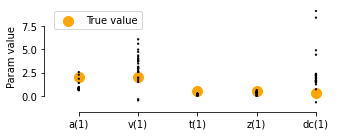

In [38]:
# Plot true vs recovered parameters:
x = np.arange(5) * 2
y0 = np.array([params0['a'], params0['v'], params0['t'], params0['z'], params0['dc']])
y1 = np.array([params1['a'], params1['v'], params1['t'], params1['z'], params1['dc']])
fig = plt.figure(figsize=(5,2))
ax = fig.add_subplot(111)
ax.scatter(x, y0, marker="o", s=100, color='orange', label='True value')
ax.scatter(x+1, y1, marker="o", s=100, color='orange',)
sns.stripplot(data=params_fitted, jitter=False, size=2, edgecolor='black', linewidth=0.25, alpha=1, palette=['black', 'black'], ax=ax)
plt.ylabel('Param value')
plt.legend()
sns.despine(offset=5, trim=True,)
plt.tight_layout()
plt.show()

In [14]:
# Plot data with model fit on top:
for c in np.unique(df_emp['condition']):
    print('CONDITION {}'.format(c))
    summary_plot(df_group=df_emp.loc[(df_emp['condition']==c),:],
                 df_sim_group=df_sim.loc[(df_emp['condition']==c),:])
    plt.show()

CONDITION 1


NameError: name 'df_sim' is not defined

In [ ]:
CONDITION 1